# Flavor Transformations

This notebook produces the figures in the SNEWPY paper showing the effect of the flavor transformation prescriptions upon the nakazato-shen-z0.004-t_rev100ms-s20.0 model 

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes

mpl.rc('font', size=18)
%matplotlib inline

In [40]:
model = Nakazato_2013(progenitor_mass=20*u.solMass, revival_time=100*u.ms, metallicity=0.004, eos='shen')
model

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|Revival time | $100$ $\mathrm{ms}$|
|Metallicity | 0.004 |
|EOS | shen |

## Transformed and untransformed energy integrated flux at Earth

Compute and plot the flux at Earth for a SN at 10 kpc with no flavor transformation, and with the chosen flavor transformation.

In [41]:
def plot_total_flux(model, xform_nmo, xform_imo):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    """
    
    energies = np.linspace(0.1,10.1,110) * u.MeV   
    D=10* u.kpc
    d = (10*u.kpc).to('cm').value # distance to SN
    mass=0.2* u.eV    
    times = model.get_time()
    burst_epoch = times <= 0.1*u.s
    accretion_epoch = (times > 0.1*u.s) & (times <= 0.5*u.s)
    cooling_epoch = (times > 0.5*u.s) & (times <= 10*u.s)
    
    ilum = {}
    olum_nmo = {}
    olum_imo = {}
    olum_nmo_tof={}
    olum_imo_tof={}
    
    for flavor in Flavor:
        ilum[flavor] = np.zeros(len(times))
        olum_nmo[flavor] = np.zeros(len(times))
        olum_imo[flavor] = np.zeros(len(times))
        olum_nmo_tof[flavor] = np.zeros(len(times))
        olum_imo_tof[flavor] = np.zeros(len(times))

    # Compute the transformed and untransformed flux at each time.
    for i, t in enumerate(times):
        ispec = model.get_initial_spectra(t, energies)
        ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
        ospec_imo = model.get_transformed_spectra(t, energies, xform_imo)
        ospec_nmo_tof = model.get_delayed_flux(D, t, energies, mass, xform_nmo)
        #ospec_imo_tof = model.get_delayed_flux(D, t, energies, mass, xform_imo)
        

        for flavor in Flavor:
            for j, E in enumerate(energies):
                ispec[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
                ospec_imo[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo_tof[flavor][j]/= (4.*np.pi*d**2)
                #ospec_imo_tof[flavor][j] /= (4.*np.pi*d**2)
                
        for flavor in Flavor:
            ilum[flavor][i] = np.trapz(ispec[flavor].to('1/(erg*s)'), energies.to('erg')).value 
            olum_nmo[flavor][i] = np.trapz(ospec_nmo[flavor].to('1/(erg*s)'), energies.to('erg')).value
            olum_imo[flavor][i] = np.trapz(ospec_imo[flavor].to('1/(erg*s)'), energies.to('erg')).value
            olum_nmo_tof[flavor][i] = np.trapz(ospec_nmo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value
            #olum_imo_tof[flavor][i] = np.trapz(ospec_imo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value
            
    # make the figures 
    fig, axes = plt.subplots(3,3, figsize=(20,12), tight_layout=True)
    
    smax = [0.,0.,0.]
    titles = ['Untransformed', 'Transformed (NMO)', 'Transformed (nmo_TOF)','Transformed (IMO)','Transformed (imo_TOF)']
    titles = ['Untransformed','Transformed (NMO)','Transformed (nmo_TOF)']
    for i, spec in enumerate([ilum, olum_nmo, olum_nmo_tof]):
        for j, phase in enumerate([burst_epoch, accretion_epoch, cooling_epoch]):
            ax = axes[i,j]
            timeunits = 'ms' if j==0 else 's'
                
            for flavor in Flavor:
                if i == 0:
                    smax[j] = np.maximum(smax[j], 1.1*np.max(spec[flavor][phase]))
                    
                ax.plot(times[phase].to(timeunits),
                        spec[flavor][phase], label=flavor.to_tex(), lw=3,
                        color='C0' if flavor.is_electron else 'C1',
                        ls='-' if flavor.is_neutrino else ':')
            
            ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),
                   ylim=(0, smax[j]))
            
            if j==0:
               ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
               ax.legend(loc='upper right', ncol=1, fontsize=18)
            if j==1:
                ax.set(title=titles[i])
            if i < 2:
                ax.set(xticklabels=[])
            else:
                ax.set(xlabel='time [{}]'.format(timeunits))
            
            ax.grid(ls=':')

      
    return fig

## Untransformed and Transformed Spectra at Earth

Compute and plot the spectra at Earth for a SN at 10 kpc with no flavor transformation, and with the chosen flavor transformation.

In [42]:
def plot_spectra12(model, xform_nmo, xform_imo, t):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    """

    energies = np.linspace(0.1,10.1,220) * u.MeV   
    D=50* u.kpc
    d = (50*u.kpc).to('cm').value # distance to SN
    mass=0.5 *u.eV    
    #get the spectra
    ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
    ospec_imo = model.get_transformed_spectra(t, energies, xform_imo)
    ospec_nmo_tof = model.get_delayed_flux(D, t, energies, mass, xform_nmo)
    ospec_imo_tof = model.get_delayed_flux(D, t, energies, mass, xform_imo)
    

    for flavor in Flavor:
        for j, E in enumerate(energies):
            
            ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
            ospec_imo[flavor][j] /= (4.*np.pi*d**2)
            ospec_nmo_tof[flavor][j] /= (4.*np.pi*d**2)
            ospec_imo_tof[flavor][j] /= (4.*np.pi*d**2)
    
    fig, axes = plt.subplots(2,2, figsize=(18,15), sharex=True, sharey=True, tight_layout=True) 
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    linestyles = ['-', '--', '-', ':', '-', '--', '-'] 
    for i, spec in enumerate([ ospec_nmo,ospec_nmo_tof]):
        axes[0][0].plot(energies, spec[Flavor.NU_E], 
                    label=f' {"transformed" if i == 0 else  " TOF"} {Flavor.NU_E.to_tex()}',
                    #label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                     color=colors[2*i], ls=linestyles[2*i] , lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X],
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_X.to_tex()}',
                    #label='Untransformed '+Flavor.NU_X.to_tex() if i==0 or 2 else 'Transformed '+Flavor.NU_X.to_tex(),
                     color=colors[2*i+1], ls=linestyles[2*i+1] , lw=2,  alpha=0.7)

        axes[0][0].set(title='Neutrinos in the NMO: $t = ${:.1f}'.format(t))
        axes[0][0].grid()
        axes[0][0].legend(loc='upper right', ncol=2, fontsize=16)
        #axes[0][0].set_xscale('log')  # Set x-axis to logarithmic scale
    
        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR],
                    label=f' {"transformed" if i == 0 else "Transformed"if i==1 else " TOF"} {Flavor.NU_E_BAR.to_tex()}',
                    #label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                     color=colors[2*i], ls=linestyles[2*i] , lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR], 
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_X_BAR.to_tex()}',
                    #label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                     color=colors[2*i+1], ls=linestyles[2*i+1] , lw=2,  alpha=0.7)

        axes[0][1].set(title='Antineutrinos in the NMO: $t = ${:.1f}'.format(t)) 
        axes[0][1].grid()
        axes[0][1].legend(loc='upper right', ncol=2, fontsize=16)
        #axes[0][1].set_xscale('log')  # Set x-axis to logarithmic scale
    
    for i, spec in enumerate([ ospec_imo, ospec_imo_tof]):
        axes[1][0].plot(energies, spec[Flavor.NU_E], 
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_E.to_tex()}',
                    #label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                     color=colors[2*i], ls=linestyles[2*i] , lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X], 
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_X.to_tex()}',
                    #label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                     color=colors[2*i], ls=linestyles[2*i+1] , lw=2,  alpha=0.7)

        axes[1][0].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Neutrinos in the IMO: $t = ${:.1f}'.format(t))
        axes[1][0].grid()
        axes[1][0].legend(loc='upper right', ncol=2, fontsize=16)
        #axes[1][0].set_xscale('log')  # Set x-axis to logarithmic scale
    
        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR], 
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_E_BAR.to_tex()}',
                    #label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                     color=colors[2*i+1], ls=linestyles[2*i] , lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR], 
                    label=f' {"transformed" if i == 0 else " TOF"} {Flavor.NU_X_BAR.to_tex()}',
                    #label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                     color=colors[2*i+1], ls=linestyles[2*i+1] , lw=2,  alpha=0.7)

        axes[1][1].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Antineutrinos in the IMO: $t = ${:.1f}'.format(t))
        axes[1][1].grid()
        axes[1][1].legend(loc='upper right', ncol=2, fontsize=18)
        #axes[1][1].set_xscale('log')  # Set x-axis to logarithmic scale

    ax = axes[0][0]
    ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    ax = axes[1][0]
    ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    
    return fig

## The following is the test part 
   For def get_delayed_flux(self, distance, arrival_time, energies, masses, flavor_xform)

In [43]:
    D=10*u.kpc
    c = 299792458 * u.m / u.s
    tof_light=D.to(u.m)/c
    #print(t)
    #print(D)
    T=10* u.ms
    #print(T)
    E = np.linspace(0.1,10.1,100) * u.MeV  
    d = (10*u.kpc).to('cm').value # distance to SN
    
    #M=np.linspace(0.1,1,5)*u.eV
    M=1* u.eV

    if M.isscalar:
        M = [M]  
    print(M)
    reslut={}
    delayed_spectrum = {}
    emission_time= {}
    for i, mass in enumerate(M):
        emission_time[i] = {}
        for j, energy in enumerate(E):
            # TOF delay formula from arXiv:1006.1889
            tof = 0.57 * ((D.value / 10)**2) * ((mass.value ** 2)) * ((30 / energy.value)** 2) * u.ms
          
            #Calculate the emission time
            emission_time[i][j] = T - tof
            
    print(emission_time[0][50])
    print("******************************************")
    print(emission_time[0][1])
    
    #Calculate the transformed spectra at the emission time    
    for i, mass in enumerate(M):
        delayed_spectrum[i] = {}
        for j, energy in enumerate(E):
            reslut = model.get_transformed_spectra(emission_time[i][j], E, AdiabaticMSW())
            #print(reslut)
            for flavor in Flavor:
                delayed_spectrum[i][flavor] = reslut[flavor]
        
    print(delayed_spectrum[0][Flavor.NU_E_BAR][50])  
    print("******************************************")
    print(delayed_spectrum[0][Flavor.NU_E_BAR][50])
    m=0.2* u.eV
    m1=2* u.eV
    E = np.linspace(0.1,10.1,100) * u.MeV  
    ospec_nmo = model.get_transformed_spectra(T, E, AdiabaticMSW())
    ospec_nmo_tof = model.get_delayed_flux(D,T,E, m, AdiabaticMSW())
    ospec_nmo_tof1 = model.get_delayed_flux(D,T,E, m1, AdiabaticMSW())
    print("******************************************")
    print(ospec_nmo[Flavor.NU_E][1] /(4.*np.pi*d**2))
    print(ospec_nmo_tof[Flavor.NU_E][1]/ (4.*np.pi*d**2))
    print(ospec_nmo_tof1[Flavor.NU_E][1]/ (4.*np.pi*d**2))
    
    
   # 8.26106759e+60, 1.24692700e+61, 1.64205782e+61, 2.00564058e+61,
   # 8.26106759e+60, 1.24692700e+61, 1.64205782e+61, 2.00564058e+61,

[<Quantity 1. eV>]
-9.338274935258163 ms
******************************************
-12686.429383096382 ms
3.2909248087283614e+57 1 / (erg s)
******************************************
3.2909248087283614e+57 1 / (erg s)
******************************************
11259805923.740913 1 / (erg s)
10685085596.878185 1 / (erg s)
4450177256.468847 1 / (erg s)


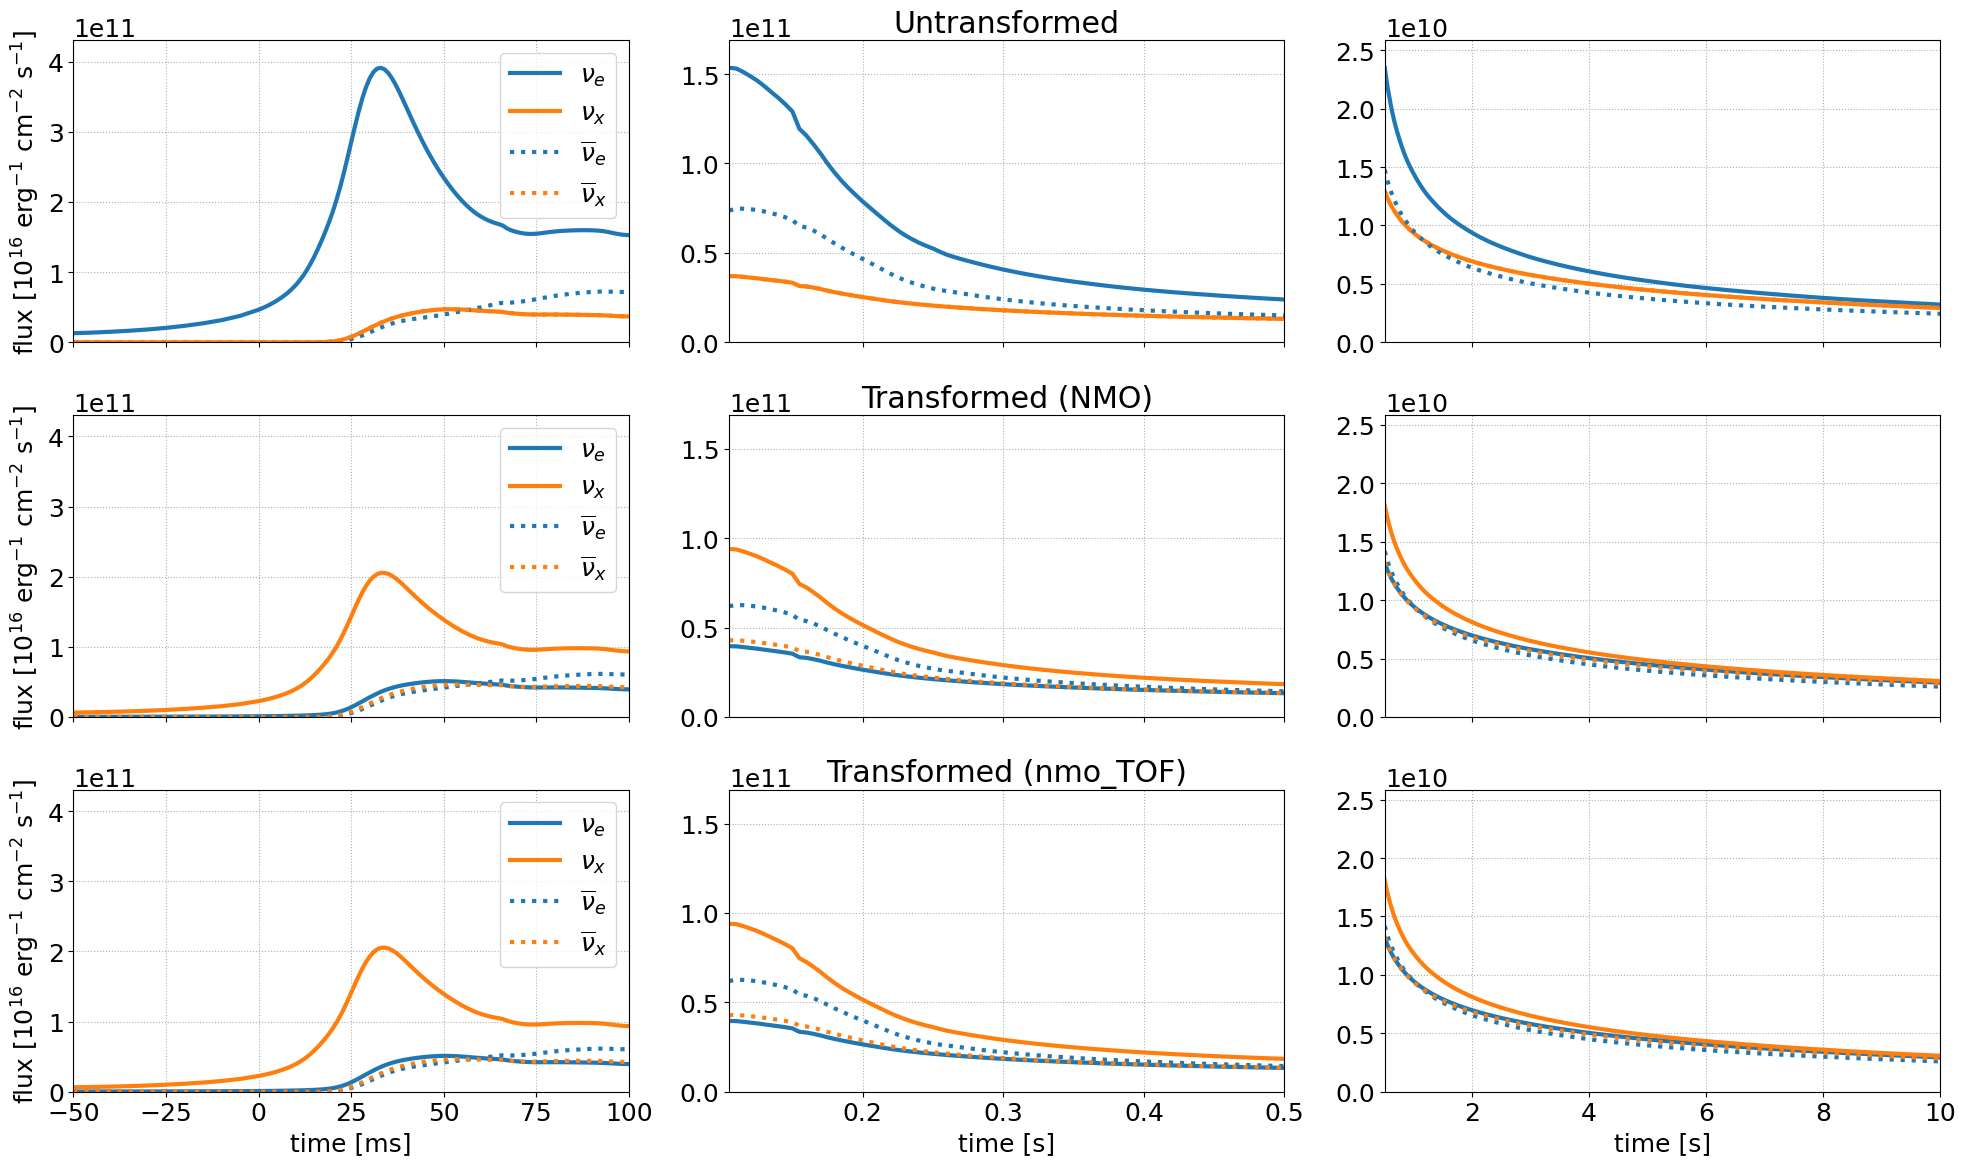

In [44]:
fig = plot_total_flux(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED) )
fig.savefig('flux_mswtest.pdf')

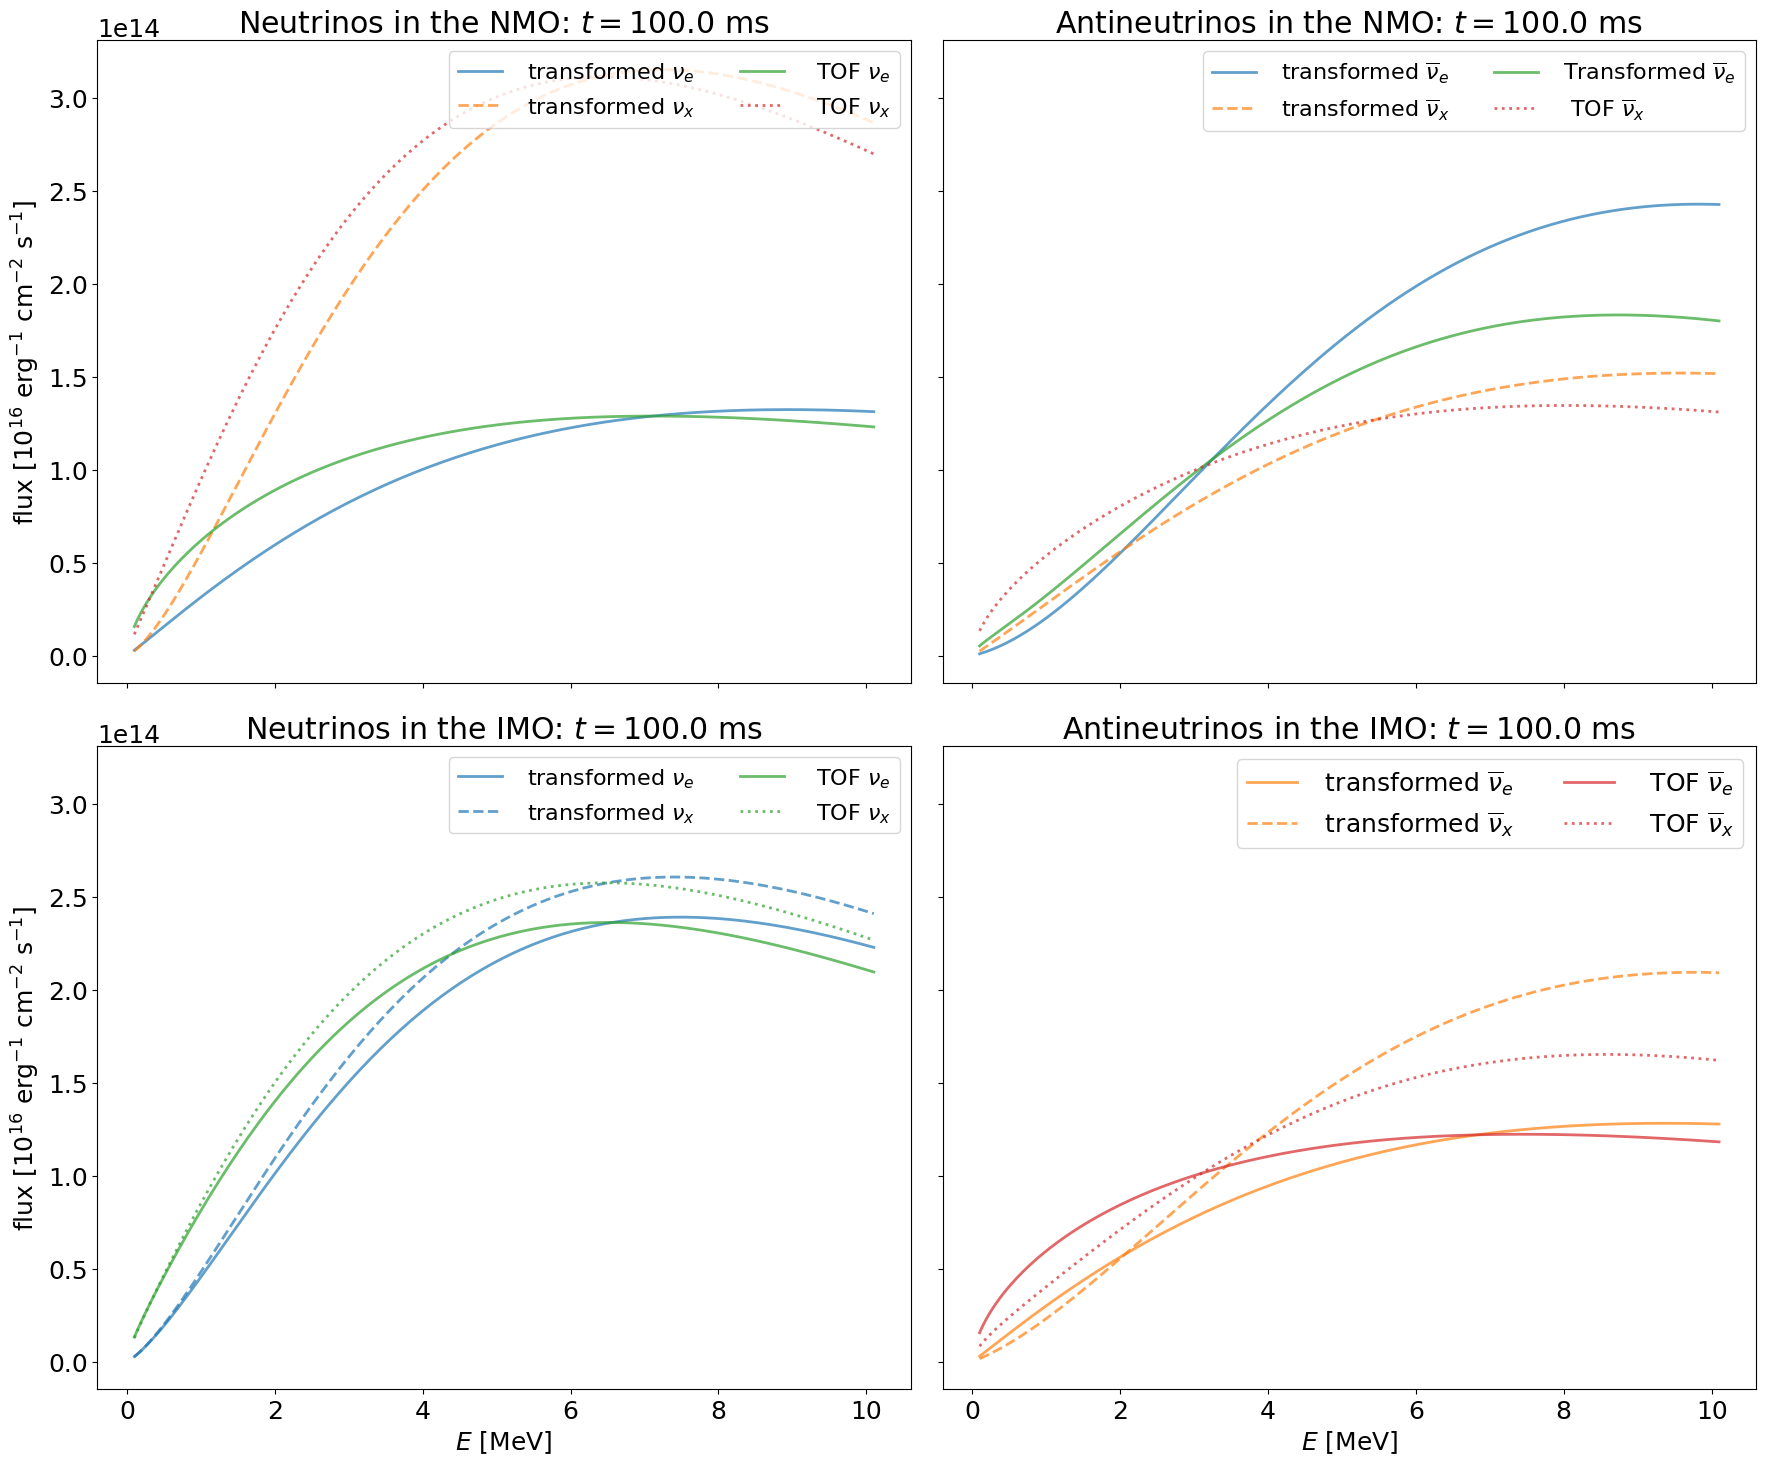

In [45]:
fig = plot_spectra12(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 100*u.ms)

fig.savefig('spectra_adiabaticmsw.pdf')

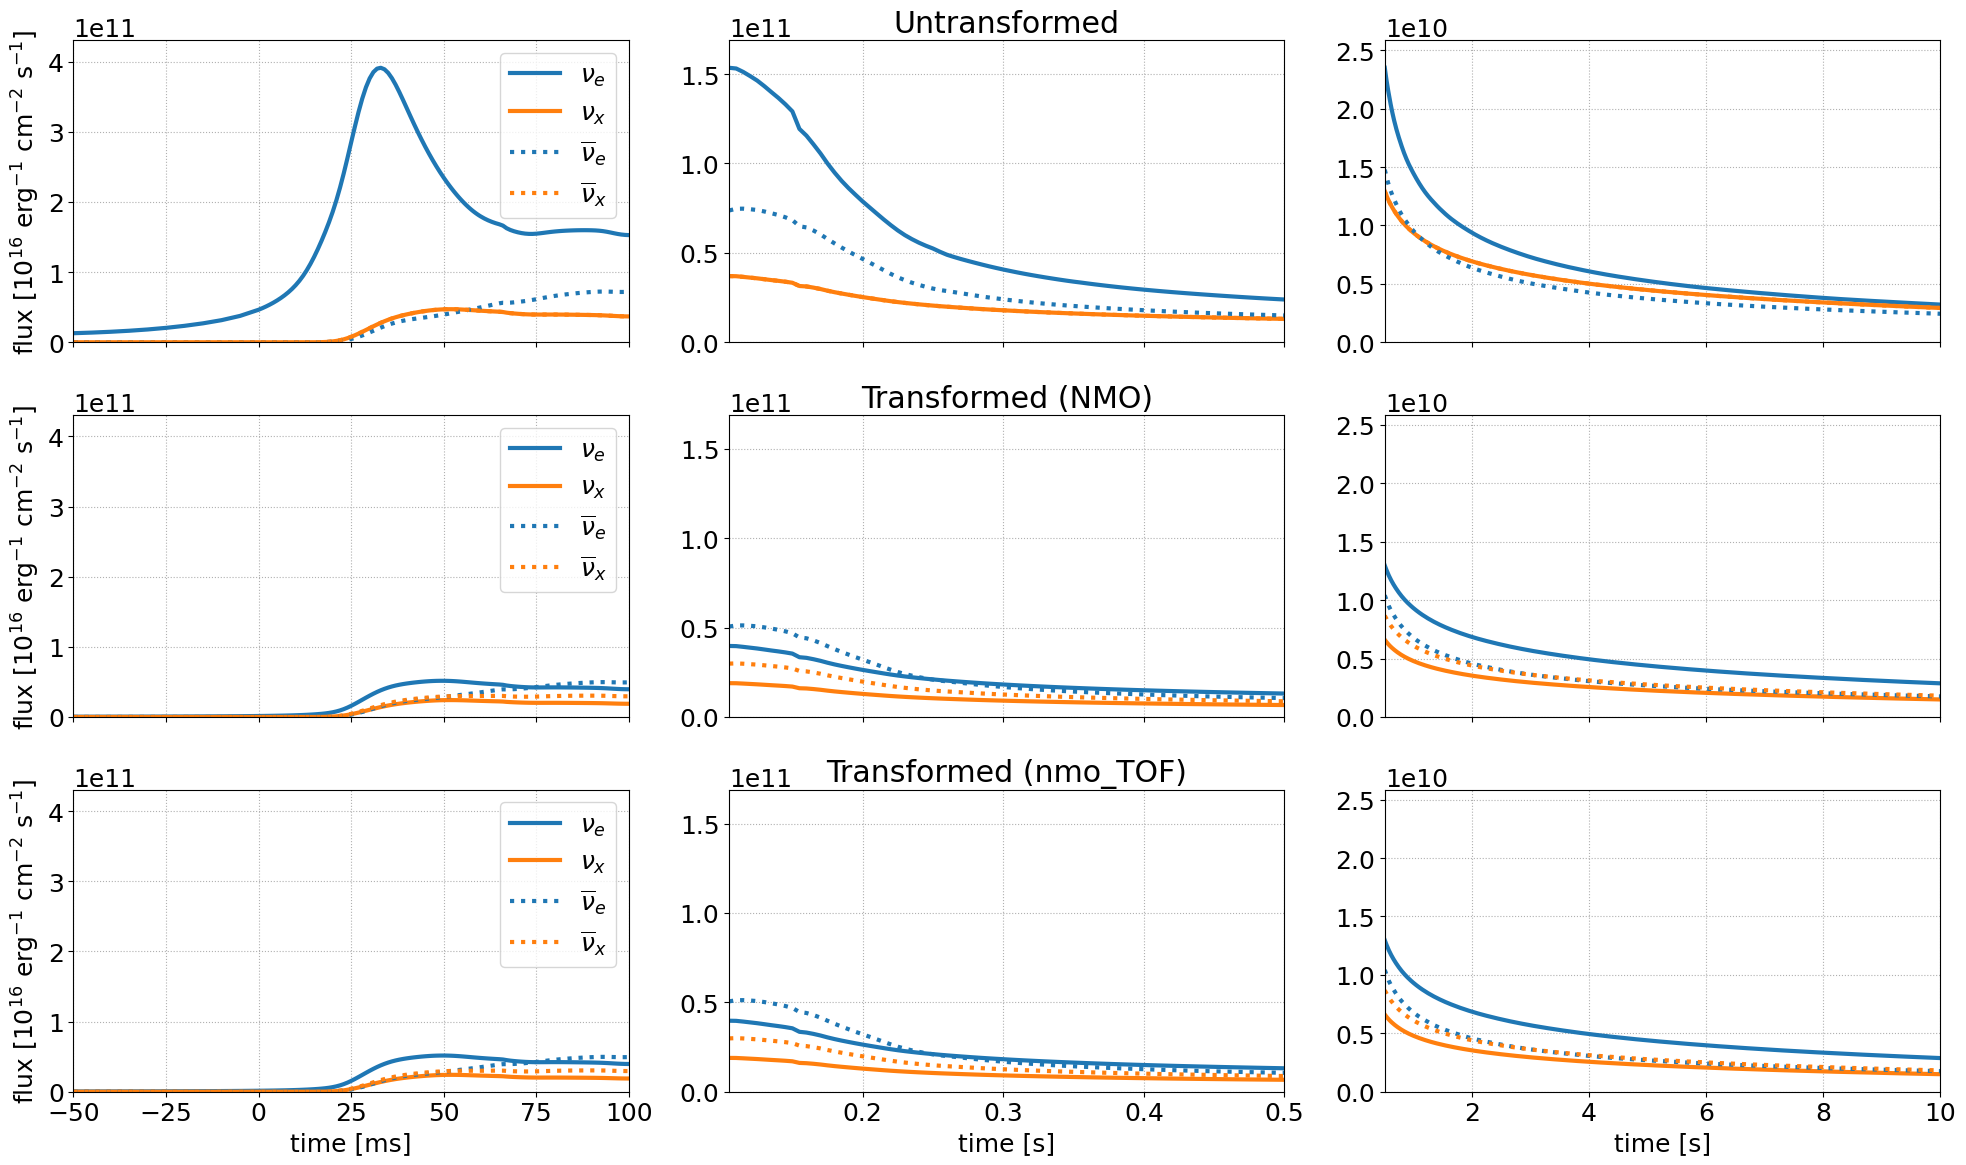

In [46]:
mp_nmo = MixingParameters()
angles_nmo = mp_nmo.get_mixing_angles() + (10*u.deg,)
xf_nmo = AdiabaticMSWes(angles_nmo)

mp_imo = MixingParameters(mh=MassHierarchy.INVERTED)
angles_imo = mp_imo.get_mixing_angles() + (10*u.deg,)
xf_imo = AdiabaticMSWes(angles_imo)

fig = plot_total_flux(model, xf_nmo, xf_imo)
fig.savefig('flux_mswstest.pdf')

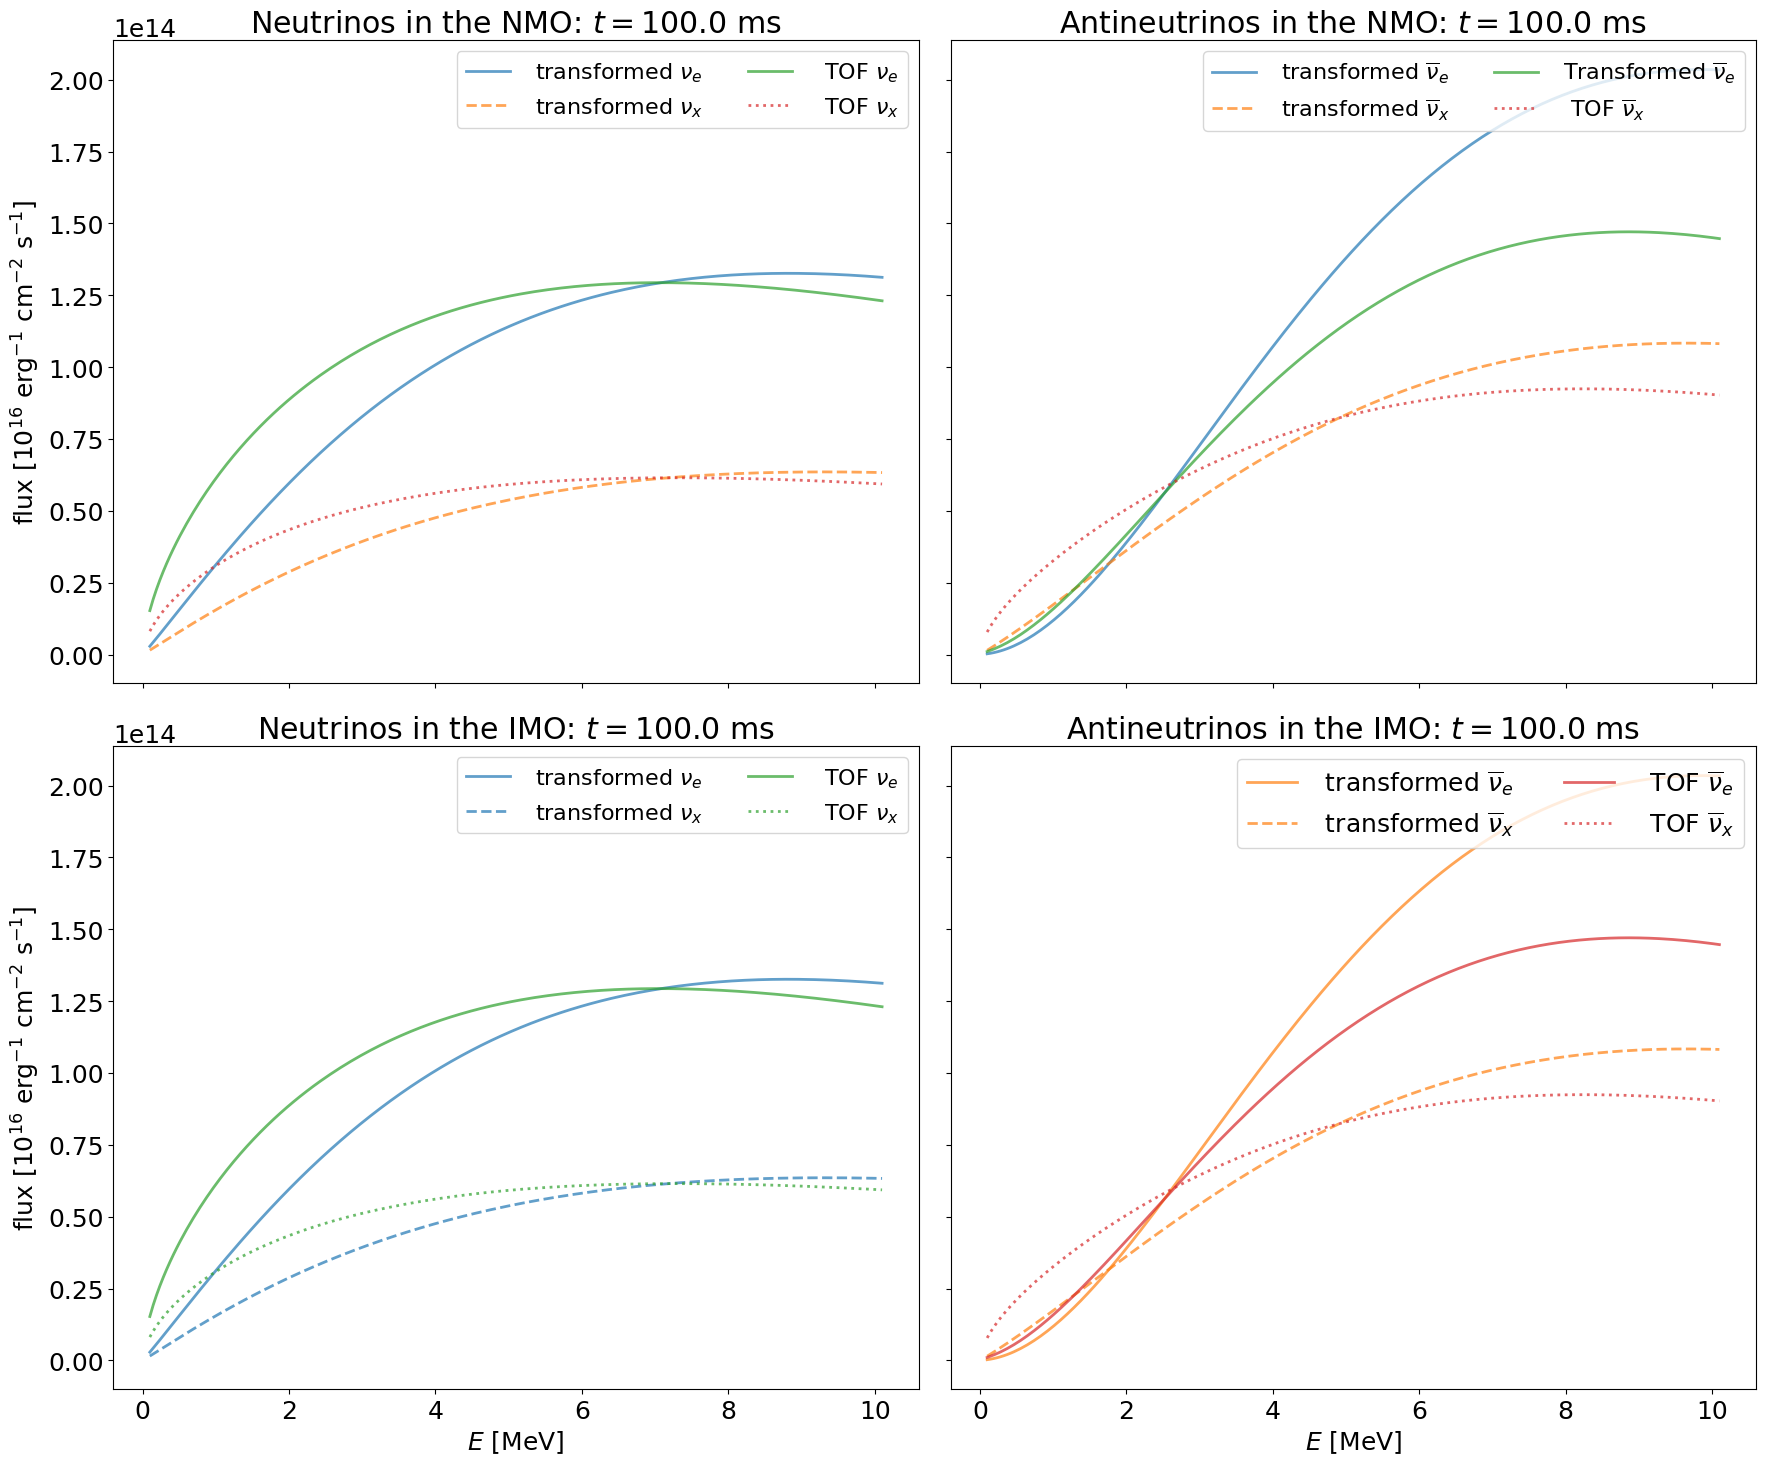

In [47]:
fig = plot_spectra12(model, xf_nmo, xf_imo, 100*u.ms)
fig.savefig('spectra_adiabaticmswes.pdf')